In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df=pd.read_csv(r"your_path\mud_divdeath\data.csv")

In [5]:
df['cell_number_at_time_0'] = df.groupby(['pupa', 'geno'])['cell number'].transform(lambda x: x[df['hAPF'] == 12].values[0])
df["cellnorm"]=df["cell number"]/df["cell_number_at_time_0"]
df["aponorm"]=df["apoptosis"]/df["cell_number_at_time_0"]
df["reintnorm"]=df["reintegrations"]/df["cell_number_at_time_0"]
df["divnorm"]=df["divisions"]/df["cell_number_at_time_0"]
df["delamnorm"]=df["delaminations"]/df["cell_number_at_time_0"]
df["attempt_div_norm"]=(df["delaminations"]+df["divisions"]+df["reintegrations"])/df["cell_number_at_time_0"]
df["eff_div"]=df["divnorm"]+df["reintnorm"]
df["div_efficiency"]=(df["divnorm"]+df["reintnorm"])/(df["divnorm"]+df["reintnorm"]+df["delamnorm"])


Production of mean and SEM for cell number, divisions, reintegration, delamination and apoptosis. Cummulative values over time of the means are calcultated.

In [6]:
summary_df = df.groupby(['hAPF', 'geno']).agg(
    mean_normalized_cell_number=('cellnorm', 'mean'),
    std_normalized_cell_number=('cellnorm', "sem"),
    mean_normalized_apoptosis=('aponorm', 'mean'),
    std_normalized_apoptosis=('aponorm', "sem"),
    mean_normalized_reintegrations=('reintnorm', 'mean'),
    std_normalized_reintegrations=('reintnorm', "sem"),
    mean_normalized_divisions=('divnorm', 'mean'),
    std_normalized_divisions=('divnorm', "sem"),
    mean_normalized_delaminations=('delamnorm', 'mean'),
    std_normalized_delaminations=('delamnorm', "sem"),
    mean_normalized_attempted_divisions=('attempt_div_norm', 'mean'),
    std_normalized_attempted_divisions=('attempt_div_norm', "sem"),
    mean_normalized_effective_divisions=('eff_div', 'mean'),
    std_normalized_effective_divisions=('eff_div', "sem"),
    mean_division_efficiency=('div_efficiency', 'mean'),
    std_division_efficiency=('div_efficiency', "sem")
    
   ).reset_index()

summary_df=summary_df.sort_values(by=["hAPF"])
summary_df["mean_cum_normalized_reintegrations"]=summary_df.groupby('geno')["mean_normalized_reintegrations"].cumsum()
summary_df["mean_cum_normalized_divisions"]=summary_df.groupby('geno')["mean_normalized_divisions"].cumsum()
summary_df["mean_cum_normalized_delaminations"]=summary_df.groupby('geno')["mean_normalized_delaminations"].cumsum()
summary_df["mean_cum_normalized_effective_divisions"]=summary_df.groupby('geno')['mean_normalized_effective_divisions'].cumsum()
summary_df["mean_cum_normalized_apoptosis"]=summary_df.groupby('geno')["mean_normalized_apoptosis"].cumsum()


Data is subsetted by genotype, for model building (see Methods) and subsequent plotting.

In [7]:
wt_data=summary_df[summary_df["geno"]=="wt"]
mud_data=summary_df[summary_df["geno"]=="mud"]
sas4_data=summary_df[summary_df["geno"]=="Sas4"]
model_data=pd.merge(wt_data,mud_data, on="hAPF")
model_data_sas=pd.merge(wt_data,sas4_data, on="hAPF")


In [8]:
model_data["wt_div_eff_mud"]=(model_data["mean_normalized_effective_divisions_x"])*model_data["mean_division_efficiency_y"]
model_data=model_data.sort_values(by=["hAPF"])
model_data["cummulative_wt_div_eff_mud"]=model_data["wt_div_eff_mud"].cumsum()

model_data["model_WT"]=1+model_data["mean_cum_normalized_effective_divisions_x"]-model_data["mean_cum_normalized_apoptosis_x"]
model_data["model_mud"]=1+model_data["mean_cum_normalized_effective_divisions_y"]-model_data["mean_cum_normalized_apoptosis_y"]
model_data["model_mud_wt_apo"]=1+model_data["mean_cum_normalized_effective_divisions_y"]-model_data["mean_cum_normalized_apoptosis_x"]
model_data["model_wt_mud_delam"]=1+model_data["cummulative_wt_div_eff_mud"]-model_data["mean_cum_normalized_apoptosis_x"]

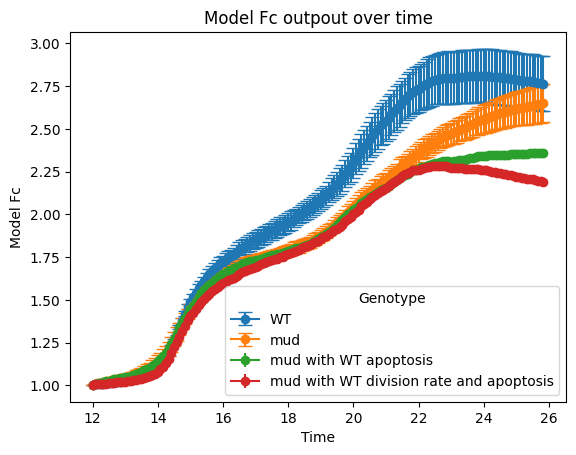

In [12]:
plt.errorbar(model_data['hAPF'], model_data['model_WT'],yerr=model_data["std_normalized_cell_number_x"],
                 label="WT", marker='o', capsize=5)
plt.errorbar(model_data['hAPF'], model_data['model_mud'],yerr=model_data["std_normalized_cell_number_y"],
                 label="mud", marker='o', capsize=5)
plt.errorbar(model_data['hAPF'], model_data['model_mud_wt_apo'],yerr=0,
                 label="mud with WT apoptosis", marker='o')
plt.errorbar(model_data['hAPF'], model_data["model_wt_mud_delam"],yerr=0,
                 label="mud with WT division rate and apoptosis", marker='o')

plt.xlabel('Time')
plt.ylabel('Model Fc')
plt.title('Model Fc outpout over time')
plt.legend(title='Genotype')

In [9]:
model_data_sas["wt_div_eff_sas"]=(model_data_sas["mean_normalized_divisions_x"]+model_data_sas["mean_normalized_reintegrations_x"])*model_data_sas["mean_division_efficiency_y"]
model_data_sas=model_data_sas.sort_values(by=["hAPF"])
model_data_sas["cummulative_wt_div_eff_sas"]=model_data_sas["wt_div_eff_sas"].cumsum()
model_data_sas["model_WT"]=1+model_data_sas["mean_cum_normalized_effective_divisions_x"]-model_data_sas["mean_cum_normalized_apoptosis_x"]
model_data_sas["model_sas"]=1+model_data_sas["mean_cum_normalized_effective_divisions_y"]-model_data_sas["mean_cum_normalized_apoptosis_y"]
model_data_sas["model_sas_wt_apo"]=1+model_data_sas["mean_cum_normalized_effective_divisions_y"]-model_data_sas["mean_cum_normalized_apoptosis_x"]
model_data_sas["model_wt_sas_delam"]=1+model_data_sas["cummulative_wt_div_eff_sas"]-model_data_sas["mean_cum_normalized_apoptosis_x"]    

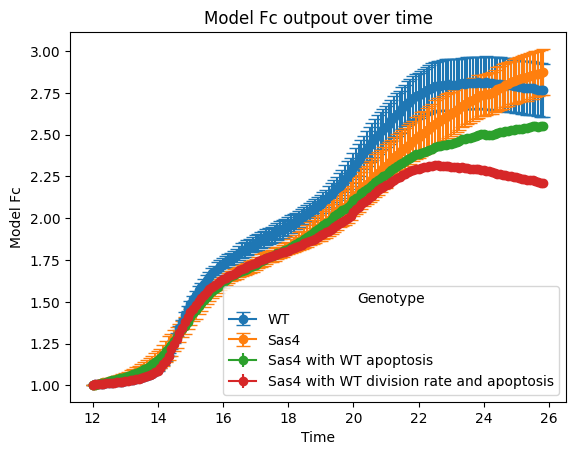

In [14]:
plt.errorbar(model_data_sas['hAPF'], model_data_sas['model_WT'],yerr=model_data_sas["std_normalized_cell_number_x"],
                 label="WT", marker='o', capsize=5)
plt.errorbar(model_data_sas['hAPF'], model_data_sas['model_sas'],yerr=model_data_sas["std_normalized_cell_number_y"],
                 label="Sas4", marker='o', capsize=5)
plt.errorbar(model_data_sas['hAPF'], model_data_sas['model_sas_wt_apo'],yerr=0,
                 label="Sas4 with WT apoptosis", marker='o')
plt.errorbar(model_data_sas['hAPF'], model_data_sas["model_wt_sas_delam"],yerr=0,
                 label="Sas4 with WT division rate and apoptosis", marker='o')

plt.xlabel('Time')
plt.ylabel('Model Fc')
plt.title('Model Fc outpout over time')
plt.legend(title='Genotype')